In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                | 0/60000 [00:00<?, ?it/s]

 12%|██▏               | 7293/60000 [00:00<00:00, 72921.72it/s]

 24%|████▏            | 14586/60000 [00:00<00:00, 70282.55it/s]

 37%|██████▏          | 21935/60000 [00:00<00:00, 71717.26it/s]

 49%|████████▏        | 29114/60000 [00:00<00:00, 67841.84it/s]

 60%|██████████▏      | 35929/60000 [00:00<00:00, 67443.00it/s]

 72%|████████████▏    | 43059/60000 [00:00<00:00, 68706.58it/s]

 84%|██████████████▎  | 50392/60000 [00:00<00:00, 70180.89it/s]

 96%|████████████████▎| 57425/60000 [00:00<00:00, 68414.58it/s]

100%|█████████████████| 60000/60000 [00:00<00:00, 69116.45it/s]

  0%|                                | 0/10000 [00:00<?, ?it/s]

 64%|███████████▍      | 6369/10000 [00:00<00:00, 63680.65it/s]

100%|█████████████████| 10000/10000 [00:00<00:00, 64705.15it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 84spf8e2


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                  | 0/184 [00:00<?, ?it/s]

  1%|▏                         | 1/184 [00:00<01:21,  2.23it/s]

  3%|▋                         | 5/184 [00:00<00:16, 11.04it/s]

  5%|█▎                        | 9/184 [00:00<00:09, 17.81it/s]

  7%|█▊                       | 13/184 [00:00<00:07, 22.88it/s]

  9%|██▎                      | 17/184 [00:00<00:06, 26.61it/s]

 11%|██▊                      | 21/184 [00:01<00:05, 29.31it/s]

 14%|███▍                     | 25/184 [00:01<00:05, 31.24it/s]

 16%|███▉                     | 29/184 [00:01<00:04, 32.62it/s]

 18%|████▍                    | 33/184 [00:01<00:04, 33.59it/s]

 20%|█████                    | 37/184 [00:01<00:04, 34.29it/s]

 22%|█████▌                   | 41/184 [00:01<00:04, 34.77it/s]

 24%|██████                   | 45/184 [00:01<00:03, 35.11it/s]

 27%|██████▋                  | 49/184 [00:01<00:03, 35.21it/s]

 29%|███████▏                 | 53/184 [00:01<00:03, 35.43it/s]

 31%|███████▋                 | 57/184 [00:02<00:03, 35.56it/s]

 33%|████████▎                | 61/184 [00:02<00:03, 35.68it/s]

 35%|████████▊                | 65/184 [00:02<00:03, 35.72it/s]

 38%|█████████▍               | 69/184 [00:02<00:03, 35.78it/s]

 40%|█████████▉               | 73/184 [00:02<00:03, 35.81it/s]

 42%|██████████▍              | 77/184 [00:02<00:02, 35.85it/s]

 44%|███████████              | 81/184 [00:02<00:02, 35.88it/s]

 46%|███████████▌             | 85/184 [00:02<00:02, 35.87it/s]

 48%|████████████             | 89/184 [00:02<00:02, 35.89it/s]

 51%|████████████▋            | 93/184 [00:03<00:02, 35.90it/s]

 53%|█████████████▏           | 97/184 [00:03<00:02, 35.89it/s]

 55%|█████████████▏          | 101/184 [00:03<00:02, 35.90it/s]

 57%|█████████████▋          | 105/184 [00:03<00:02, 35.91it/s]

 59%|██████████████▏         | 109/184 [00:03<00:02, 35.89it/s]

 61%|██████████████▋         | 113/184 [00:03<00:01, 35.91it/s]

 64%|███████████████▎        | 117/184 [00:03<00:01, 35.92it/s]

 66%|███████████████▊        | 121/184 [00:03<00:01, 35.86it/s]

 68%|████████████████▎       | 125/184 [00:03<00:01, 35.84it/s]

 70%|████████████████▊       | 129/184 [00:04<00:01, 35.87it/s]

 72%|█████████████████▎      | 133/184 [00:04<00:01, 35.90it/s]

 74%|█████████████████▊      | 137/184 [00:04<00:01, 35.89it/s]

 77%|██████████████████▍     | 141/184 [00:04<00:01, 35.91it/s]

 79%|██████████████████▉     | 145/184 [00:04<00:01, 35.92it/s]

 81%|███████████████████▍    | 149/184 [00:04<00:00, 35.92it/s]

 83%|███████████████████▉    | 153/184 [00:04<00:00, 35.92it/s]

 85%|████████████████████▍   | 157/184 [00:04<00:00, 35.91it/s]

 88%|█████████████████████   | 161/184 [00:04<00:00, 35.91it/s]

 90%|█████████████████████▌  | 165/184 [00:05<00:00, 35.91it/s]

 92%|██████████████████████  | 169/184 [00:05<00:00, 35.92it/s]

 94%|██████████████████████▌ | 173/184 [00:05<00:00, 35.93it/s]

 96%|███████████████████████ | 177/184 [00:05<00:00, 35.87it/s]

 98%|███████████████████████▌| 181/184 [00:05<00:00, 35.92it/s]

100%|████████████████████████| 184/184 [00:05<00:00, 32.90it/s]

train - OK


  0%|                                   | 0/46 [00:00<?, ?it/s]

  4%|█▏                         | 2/46 [00:00<00:02, 15.81it/s]

 13%|███▌                       | 6/46 [00:00<00:01, 26.86it/s]

 22%|█████▋                    | 10/46 [00:00<00:01, 30.83it/s]

 30%|███████▉                  | 14/46 [00:00<00:00, 32.79it/s]

 39%|██████████▏               | 18/46 [00:00<00:00, 33.89it/s]

 48%|████████████▍             | 22/46 [00:00<00:00, 34.56it/s]

 57%|██████████████▋           | 26/46 [00:00<00:00, 34.98it/s]

 65%|████████████████▉         | 30/46 [00:00<00:00, 35.27it/s]

 74%|███████████████████▏      | 34/46 [00:01<00:00, 35.46it/s]

 83%|█████████████████████▍    | 38/46 [00:01<00:00, 35.58it/s]

 91%|███████████████████████▋  | 42/46 [00:01<00:00, 35.69it/s]

100%|██████████████████████████| 46/46 [00:01<00:00, 32.94it/s]

100%|██████████████████████████| 46/46 [00:01<00:00, 32.59it/s]

val - OK


  0%|                                   | 0/38 [00:00<?, ?it/s]

  3%|▋                          | 1/38 [00:00<00:03, 10.00it/s]

 13%|███▌                       | 5/38 [00:00<00:01, 25.72it/s]

 24%|██████▍                    | 9/38 [00:00<00:00, 30.43it/s]

 34%|████████▉                 | 13/38 [00:00<00:00, 32.60it/s]

 45%|███████████▋              | 17/38 [00:00<00:00, 33.78it/s]

 55%|██████████████▎           | 21/38 [00:00<00:00, 34.48it/s]

 66%|█████████████████         | 25/38 [00:00<00:00, 34.92it/s]

 76%|███████████████████▊      | 29/38 [00:00<00:00, 35.22it/s]

 87%|██████████████████████▌   | 33/38 [00:00<00:00, 35.43it/s]

 97%|█████████████████████████▎| 37/38 [00:01<00:00, 35.61it/s]

100%|██████████████████████████| 38/38 [00:01<00:00, 31.85it/s]

test InD - OK


  0%|                                  | 0/280 [00:00<?, ?it/s]

  0%|                          | 1/280 [00:00<00:29,  9.37it/s]

  2%|▍                         | 5/280 [00:00<00:10, 25.06it/s]

  3%|▊                         | 9/280 [00:00<00:09, 30.00it/s]

  5%|█▏                       | 13/280 [00:00<00:08, 32.32it/s]

  6%|█▌                       | 17/280 [00:00<00:07, 33.44it/s]

  8%|█▉                       | 21/280 [00:00<00:07, 34.26it/s]

  9%|██▏                      | 25/280 [00:00<00:07, 34.78it/s]

 10%|██▌                      | 29/280 [00:00<00:07, 35.13it/s]

 12%|██▉                      | 33/280 [00:01<00:06, 35.36it/s]

 13%|███▎                     | 37/280 [00:01<00:06, 35.53it/s]

 15%|███▋                     | 41/280 [00:01<00:06, 35.63it/s]

 16%|████                     | 45/280 [00:01<00:06, 35.70it/s]

 18%|████▍                    | 49/280 [00:01<00:06, 35.75it/s]

 19%|████▋                    | 53/280 [00:01<00:06, 35.80it/s]

 20%|█████                    | 57/280 [00:01<00:06, 35.81it/s]

 22%|█████▍                   | 61/280 [00:01<00:06, 35.84it/s]

 23%|█████▊                   | 65/280 [00:01<00:05, 35.84it/s]

 25%|██████▏                  | 69/280 [00:02<00:05, 35.86it/s]

 26%|██████▌                  | 73/280 [00:02<00:05, 35.65it/s]

 28%|██████▉                  | 77/280 [00:02<00:05, 35.73it/s]

 29%|███████▏                 | 81/280 [00:02<00:05, 35.78it/s]

 30%|███████▌                 | 85/280 [00:02<00:05, 35.80it/s]

 32%|███████▉                 | 89/280 [00:02<00:05, 35.83it/s]

 33%|████████▎                | 93/280 [00:02<00:05, 35.85it/s]

 35%|████████▋                | 97/280 [00:02<00:05, 35.84it/s]

 36%|████████▋               | 101/280 [00:02<00:04, 35.86it/s]

 38%|█████████               | 105/280 [00:03<00:04, 35.87it/s]

 39%|█████████▎              | 109/280 [00:03<00:04, 35.85it/s]

 40%|█████████▋              | 113/280 [00:03<00:04, 35.87it/s]

 42%|██████████              | 117/280 [00:03<00:04, 35.88it/s]

 43%|██████████▎             | 121/280 [00:03<00:04, 35.85it/s]

 45%|██████████▋             | 125/280 [00:03<00:04, 35.87it/s]

 46%|███████████             | 129/280 [00:03<00:04, 35.87it/s]

 48%|███████████▍            | 133/280 [00:03<00:04, 35.88it/s]

 49%|███████████▋            | 137/280 [00:03<00:03, 35.86it/s]

 50%|████████████            | 141/280 [00:04<00:03, 35.89it/s]

 52%|████████████▍           | 145/280 [00:04<00:03, 35.78it/s]

 53%|████████████▊           | 149/280 [00:04<00:03, 35.81it/s]

 55%|█████████████           | 153/280 [00:04<00:03, 35.83it/s]

 56%|█████████████▍          | 157/280 [00:04<00:03, 35.83it/s]

 57%|█████████████▊          | 161/280 [00:04<00:03, 35.85it/s]

 59%|██████████████▏         | 165/280 [00:04<00:03, 35.87it/s]

 60%|██████████████▍         | 169/280 [00:04<00:03, 35.87it/s]

 62%|██████████████▊         | 173/280 [00:04<00:02, 35.86it/s]

 63%|███████████████▏        | 177/280 [00:05<00:02, 35.85it/s]

 65%|███████████████▌        | 181/280 [00:05<00:02, 35.86it/s]

 66%|███████████████▊        | 185/280 [00:05<00:02, 35.86it/s]

 68%|████████████████▏       | 189/280 [00:05<00:02, 35.87it/s]

 69%|████████████████▌       | 193/280 [00:05<00:02, 35.87it/s]

 70%|████████████████▉       | 197/280 [00:05<00:02, 35.84it/s]

 72%|█████████████████▏      | 201/280 [00:05<00:02, 35.87it/s]

 73%|█████████████████▌      | 205/280 [00:05<00:02, 35.88it/s]

 75%|█████████████████▉      | 209/280 [00:05<00:01, 35.88it/s]

 76%|██████████████████▎     | 213/280 [00:06<00:01, 35.88it/s]

 78%|██████████████████▌     | 217/280 [00:06<00:01, 35.88it/s]

 79%|██████████████████▉     | 221/280 [00:06<00:01, 35.84it/s]

 80%|███████████████████▎    | 225/280 [00:06<00:01, 35.88it/s]

 82%|███████████████████▋    | 229/280 [00:06<00:01, 35.88it/s]

 83%|███████████████████▉    | 233/280 [00:06<00:01, 35.88it/s]

 85%|████████████████████▎   | 237/280 [00:06<00:01, 35.87it/s]

 86%|████████████████████▋   | 241/280 [00:06<00:01, 35.87it/s]

 88%|█████████████████████   | 245/280 [00:06<00:00, 35.88it/s]

 89%|█████████████████████▎  | 249/280 [00:07<00:00, 35.83it/s]

 90%|█████████████████████▋  | 253/280 [00:07<00:00, 35.87it/s]

 92%|██████████████████████  | 257/280 [00:07<00:00, 35.88it/s]

 93%|██████████████████████▎ | 261/280 [00:07<00:00, 35.88it/s]

 95%|██████████████████████▋ | 265/280 [00:07<00:00, 35.88it/s]

 96%|███████████████████████ | 269/280 [00:07<00:00, 35.88it/s]

 98%|███████████████████████▍| 273/280 [00:07<00:00, 35.88it/s]

 99%|███████████████████████▋| 277/280 [00:07<00:00, 35.90it/s]

100%|████████████████████████| 280/280 [00:07<00:00, 35.11it/s]

test OoD - OK


  0%|                                  | 0/100 [00:00<?, ?it/s]

  4%|█                         | 4/100 [00:00<00:02, 36.88it/s]

  8%|██                        | 8/100 [00:00<00:02, 36.96it/s]

 12%|███                      | 12/100 [00:00<00:02, 36.90it/s]

 16%|████                     | 16/100 [00:00<00:02, 36.54it/s]

 20%|█████                    | 20/100 [00:00<00:02, 36.34it/s]

 24%|██████                   | 24/100 [00:00<00:02, 36.24it/s]

 28%|███████                  | 28/100 [00:00<00:01, 36.18it/s]

 32%|████████                 | 32/100 [00:00<00:01, 36.13it/s]

 36%|█████████                | 36/100 [00:00<00:01, 36.10it/s]

 40%|██████████               | 40/100 [00:01<00:01, 36.07it/s]

 44%|███████████              | 44/100 [00:01<00:01, 36.05it/s]

 48%|████████████             | 48/100 [00:01<00:01, 36.05it/s]

 52%|█████████████            | 52/100 [00:01<00:01, 36.03it/s]

 56%|██████████████           | 56/100 [00:01<00:01, 36.02it/s]

 60%|███████████████          | 60/100 [00:01<00:01, 36.03it/s]

 64%|████████████████         | 64/100 [00:01<00:01, 35.85it/s]

 68%|█████████████████        | 68/100 [00:01<00:00, 35.89it/s]

 72%|██████████████████       | 72/100 [00:01<00:00, 35.93it/s]

 76%|███████████████████      | 76/100 [00:02<00:00, 35.94it/s]

 80%|████████████████████     | 80/100 [00:02<00:00, 35.95it/s]

 84%|█████████████████████    | 84/100 [00:02<00:00, 35.93it/s]

 88%|██████████████████████   | 88/100 [00:02<00:00, 35.96it/s]

 92%|███████████████████████  | 92/100 [00:02<00:00, 35.99it/s]

 96%|████████████████████████ | 96/100 [00:02<00:00, 35.98it/s]

100%|████████████████████████| 100/100 [00:02<00:00, 35.99it/s]

100%|████████████████████████| 100/100 [00:02<00:00, 36.08it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(23523, 1, 32, 32) (23523, 1, 32, 32) (23523, 256) (23523, 5) (23523,)
(5881, 1, 32, 32) (5881, 1, 32, 32) (5881, 256) (5881, 5) (5881,)
(4861, 1, 32, 32) (4861, 1, 32, 32) (4861, 256) (4861, 5) (4861,)
(35735, 1, 32, 32) (35735, 1, 32, 32) (35735, 256) (35735, 5) (35735,)
(12800, 1, 32, 32) (12800, 1, 32, 32) (12800, 256) (12800, 5)


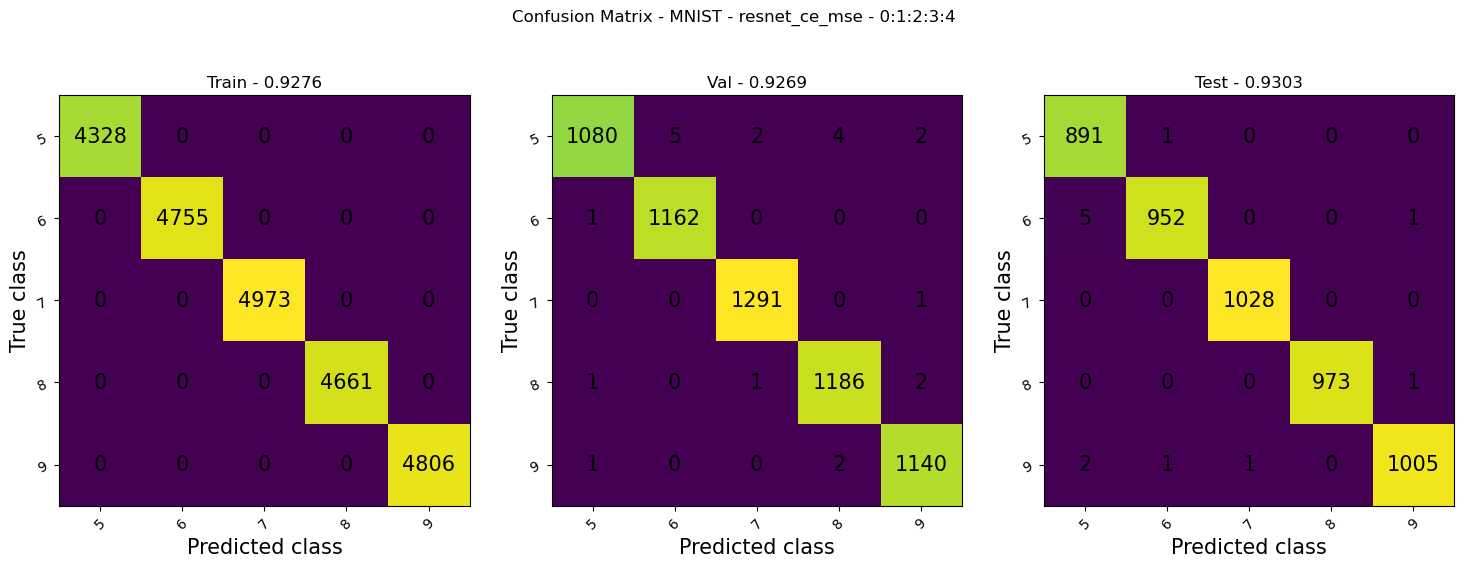

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(4861, 2) (35735, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(4861, 2) (35735, 2)


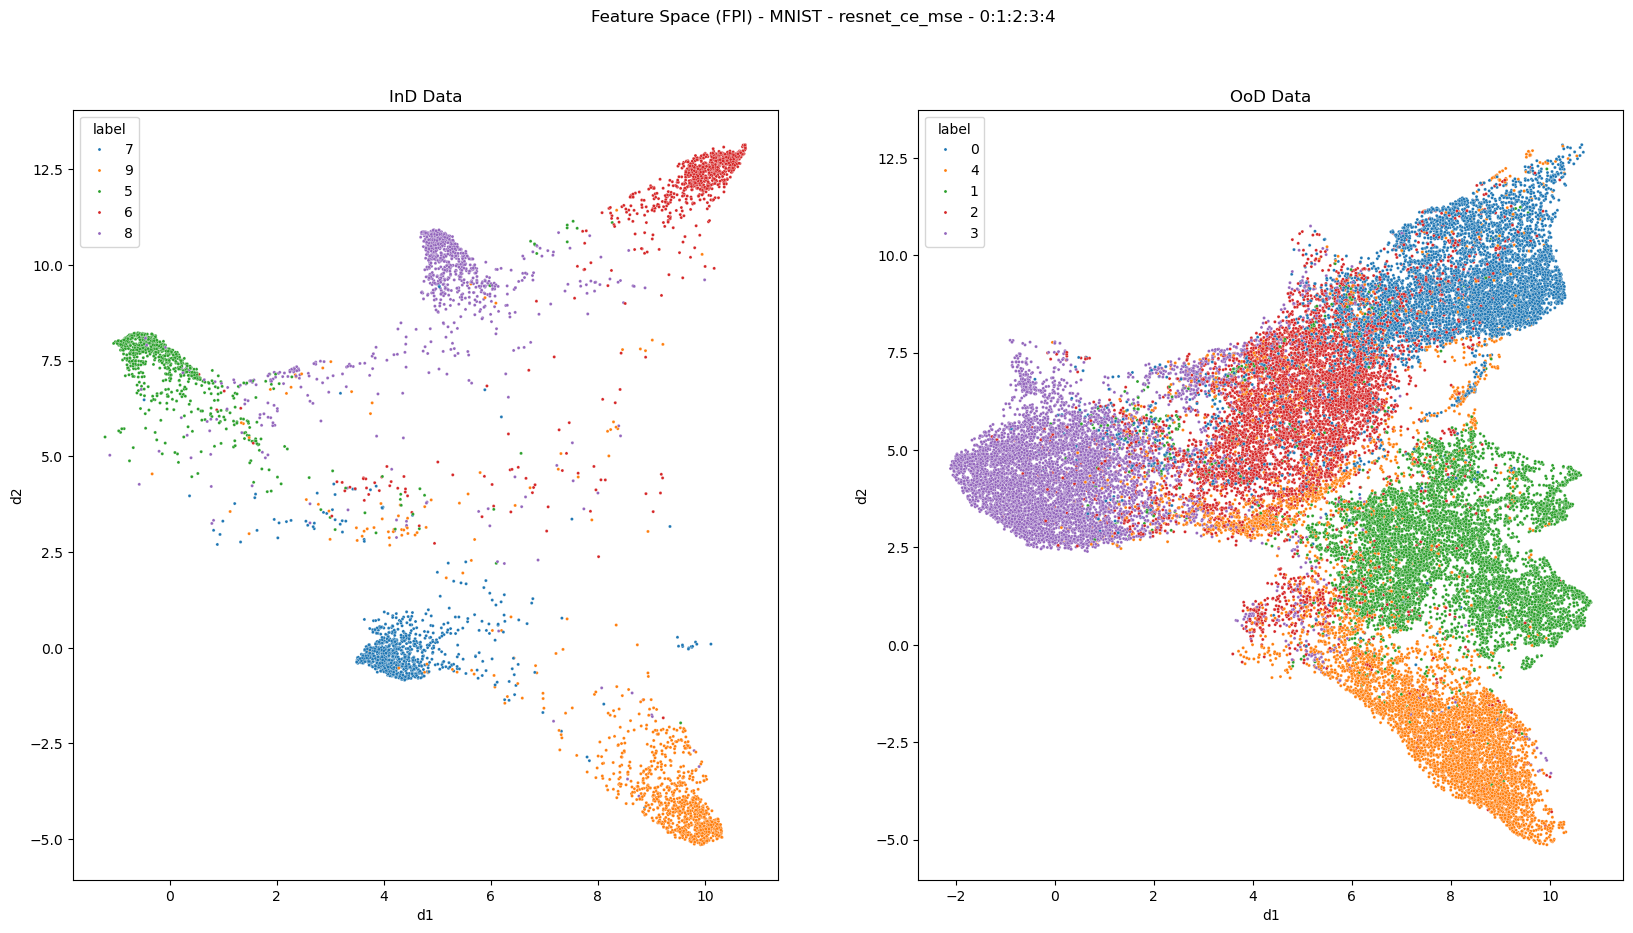

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

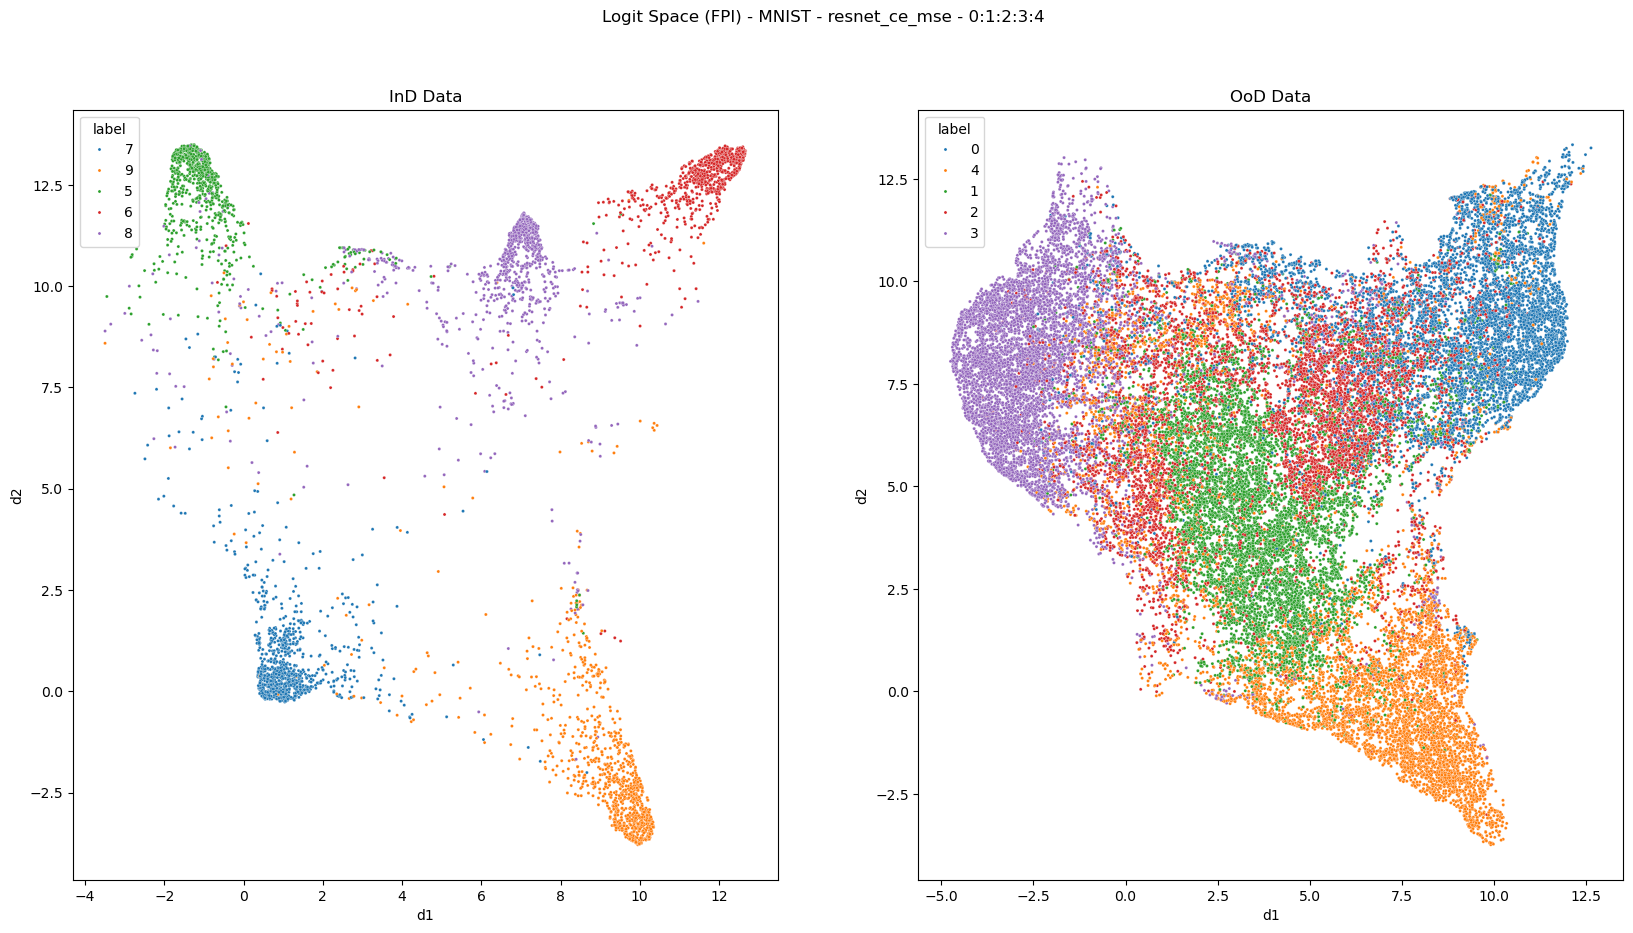

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

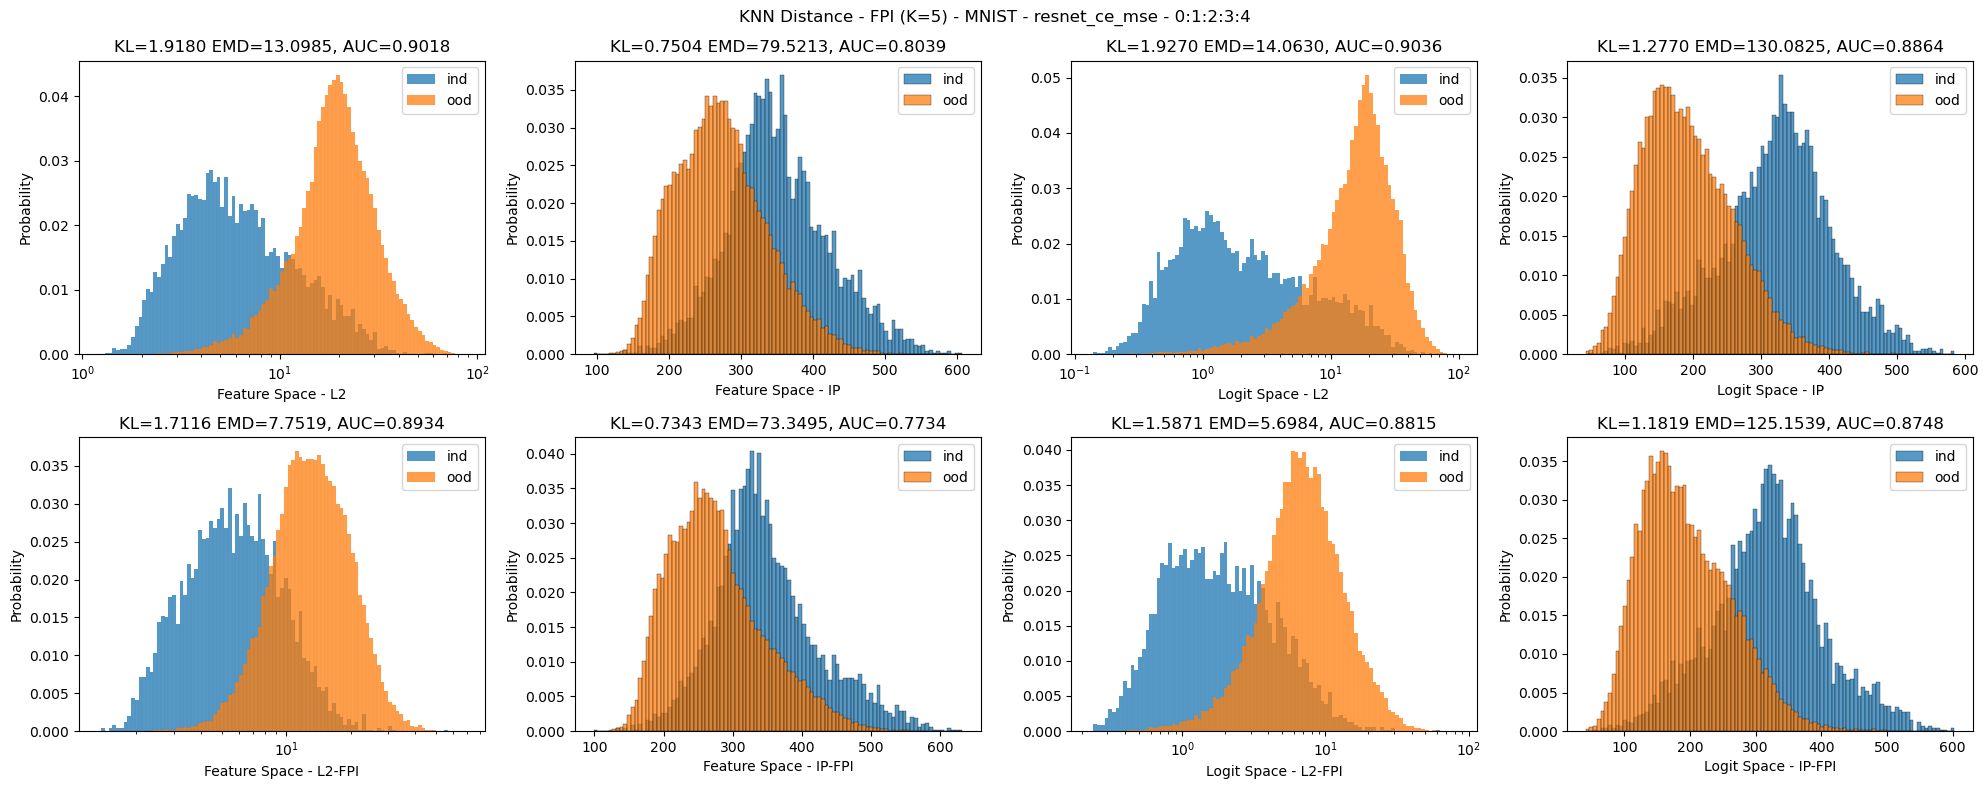

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

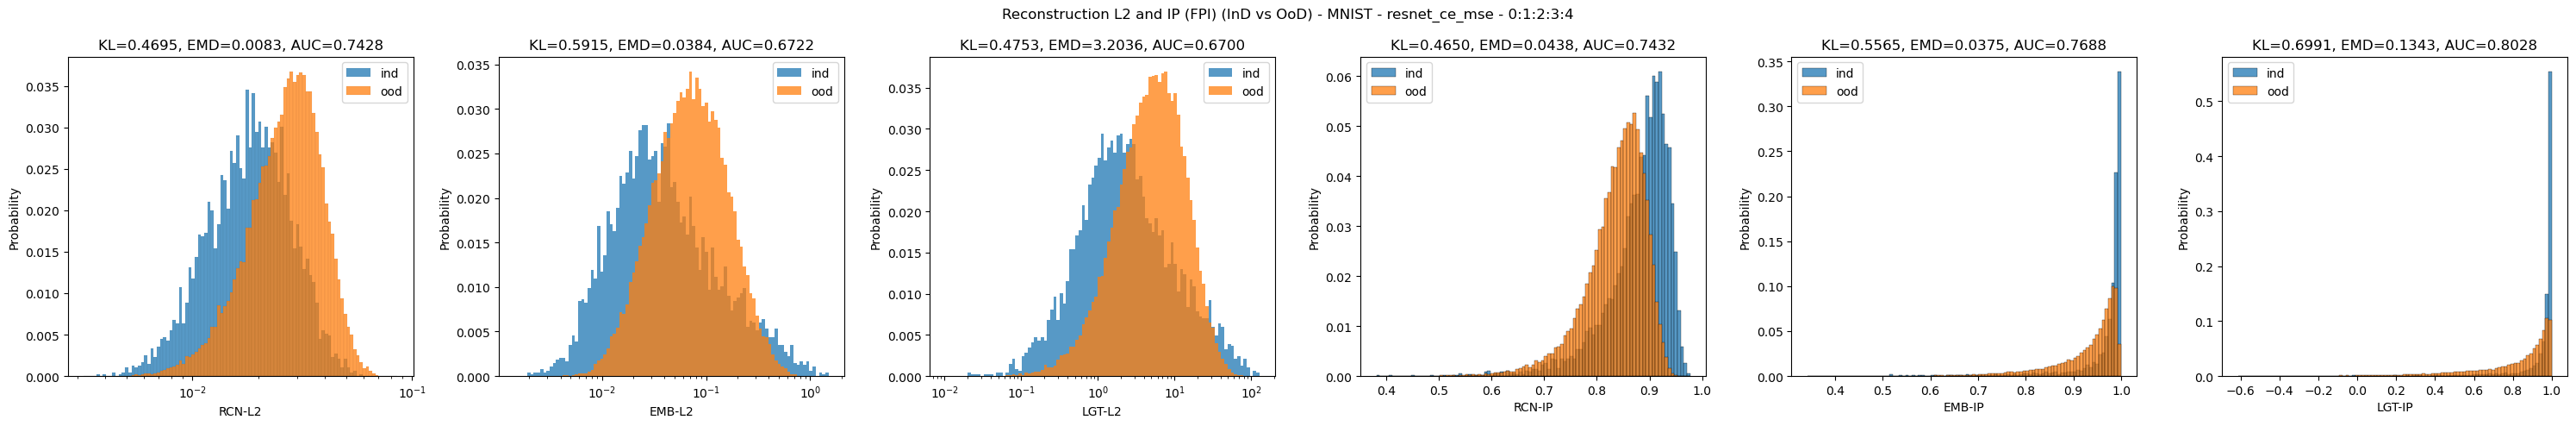

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

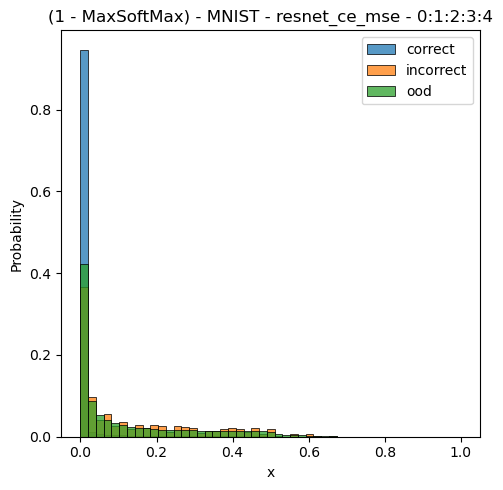

In [17]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()